# 1. Load the data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# !pip install --upgrade seaborn

#!pip show seaborn

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
train_data = train_data.replace([np.inf, -np.inf], np.nan)
train_data.head()
n_train = len(train_data)
n_test = len(test_data)
train_data.drop(['Id'], axis=1, inplace=True)
print(n_train, n_test)

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
1460 1459


# 2. Modify target variable to fit normal distribution
* We can use a log transformation since our data is right skewed
* Don't forget to convert log back with exponential transformation when making our predictions

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

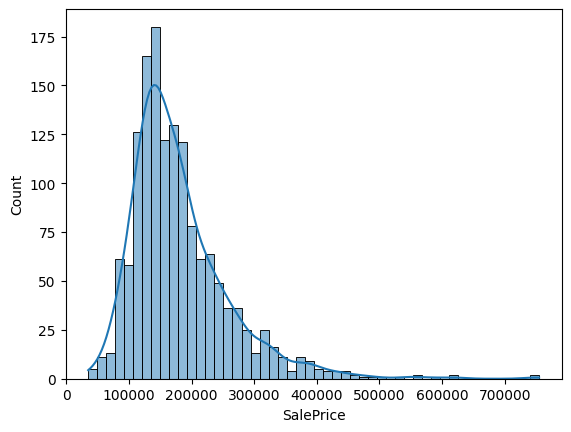

In [2]:
sns.histplot(train_data['SalePrice'], kde=True, bins=50)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice_log', ylabel='Count'>

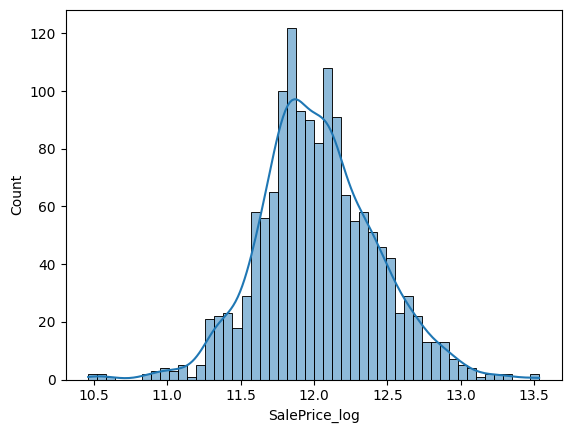

In [3]:
train_data['SalePrice_log'] = np.log(train_data['SalePrice'])
sns.histplot(train_data['SalePrice_log'], kde=True, bins=50)

# 3. Remove outliers

<Axes: >

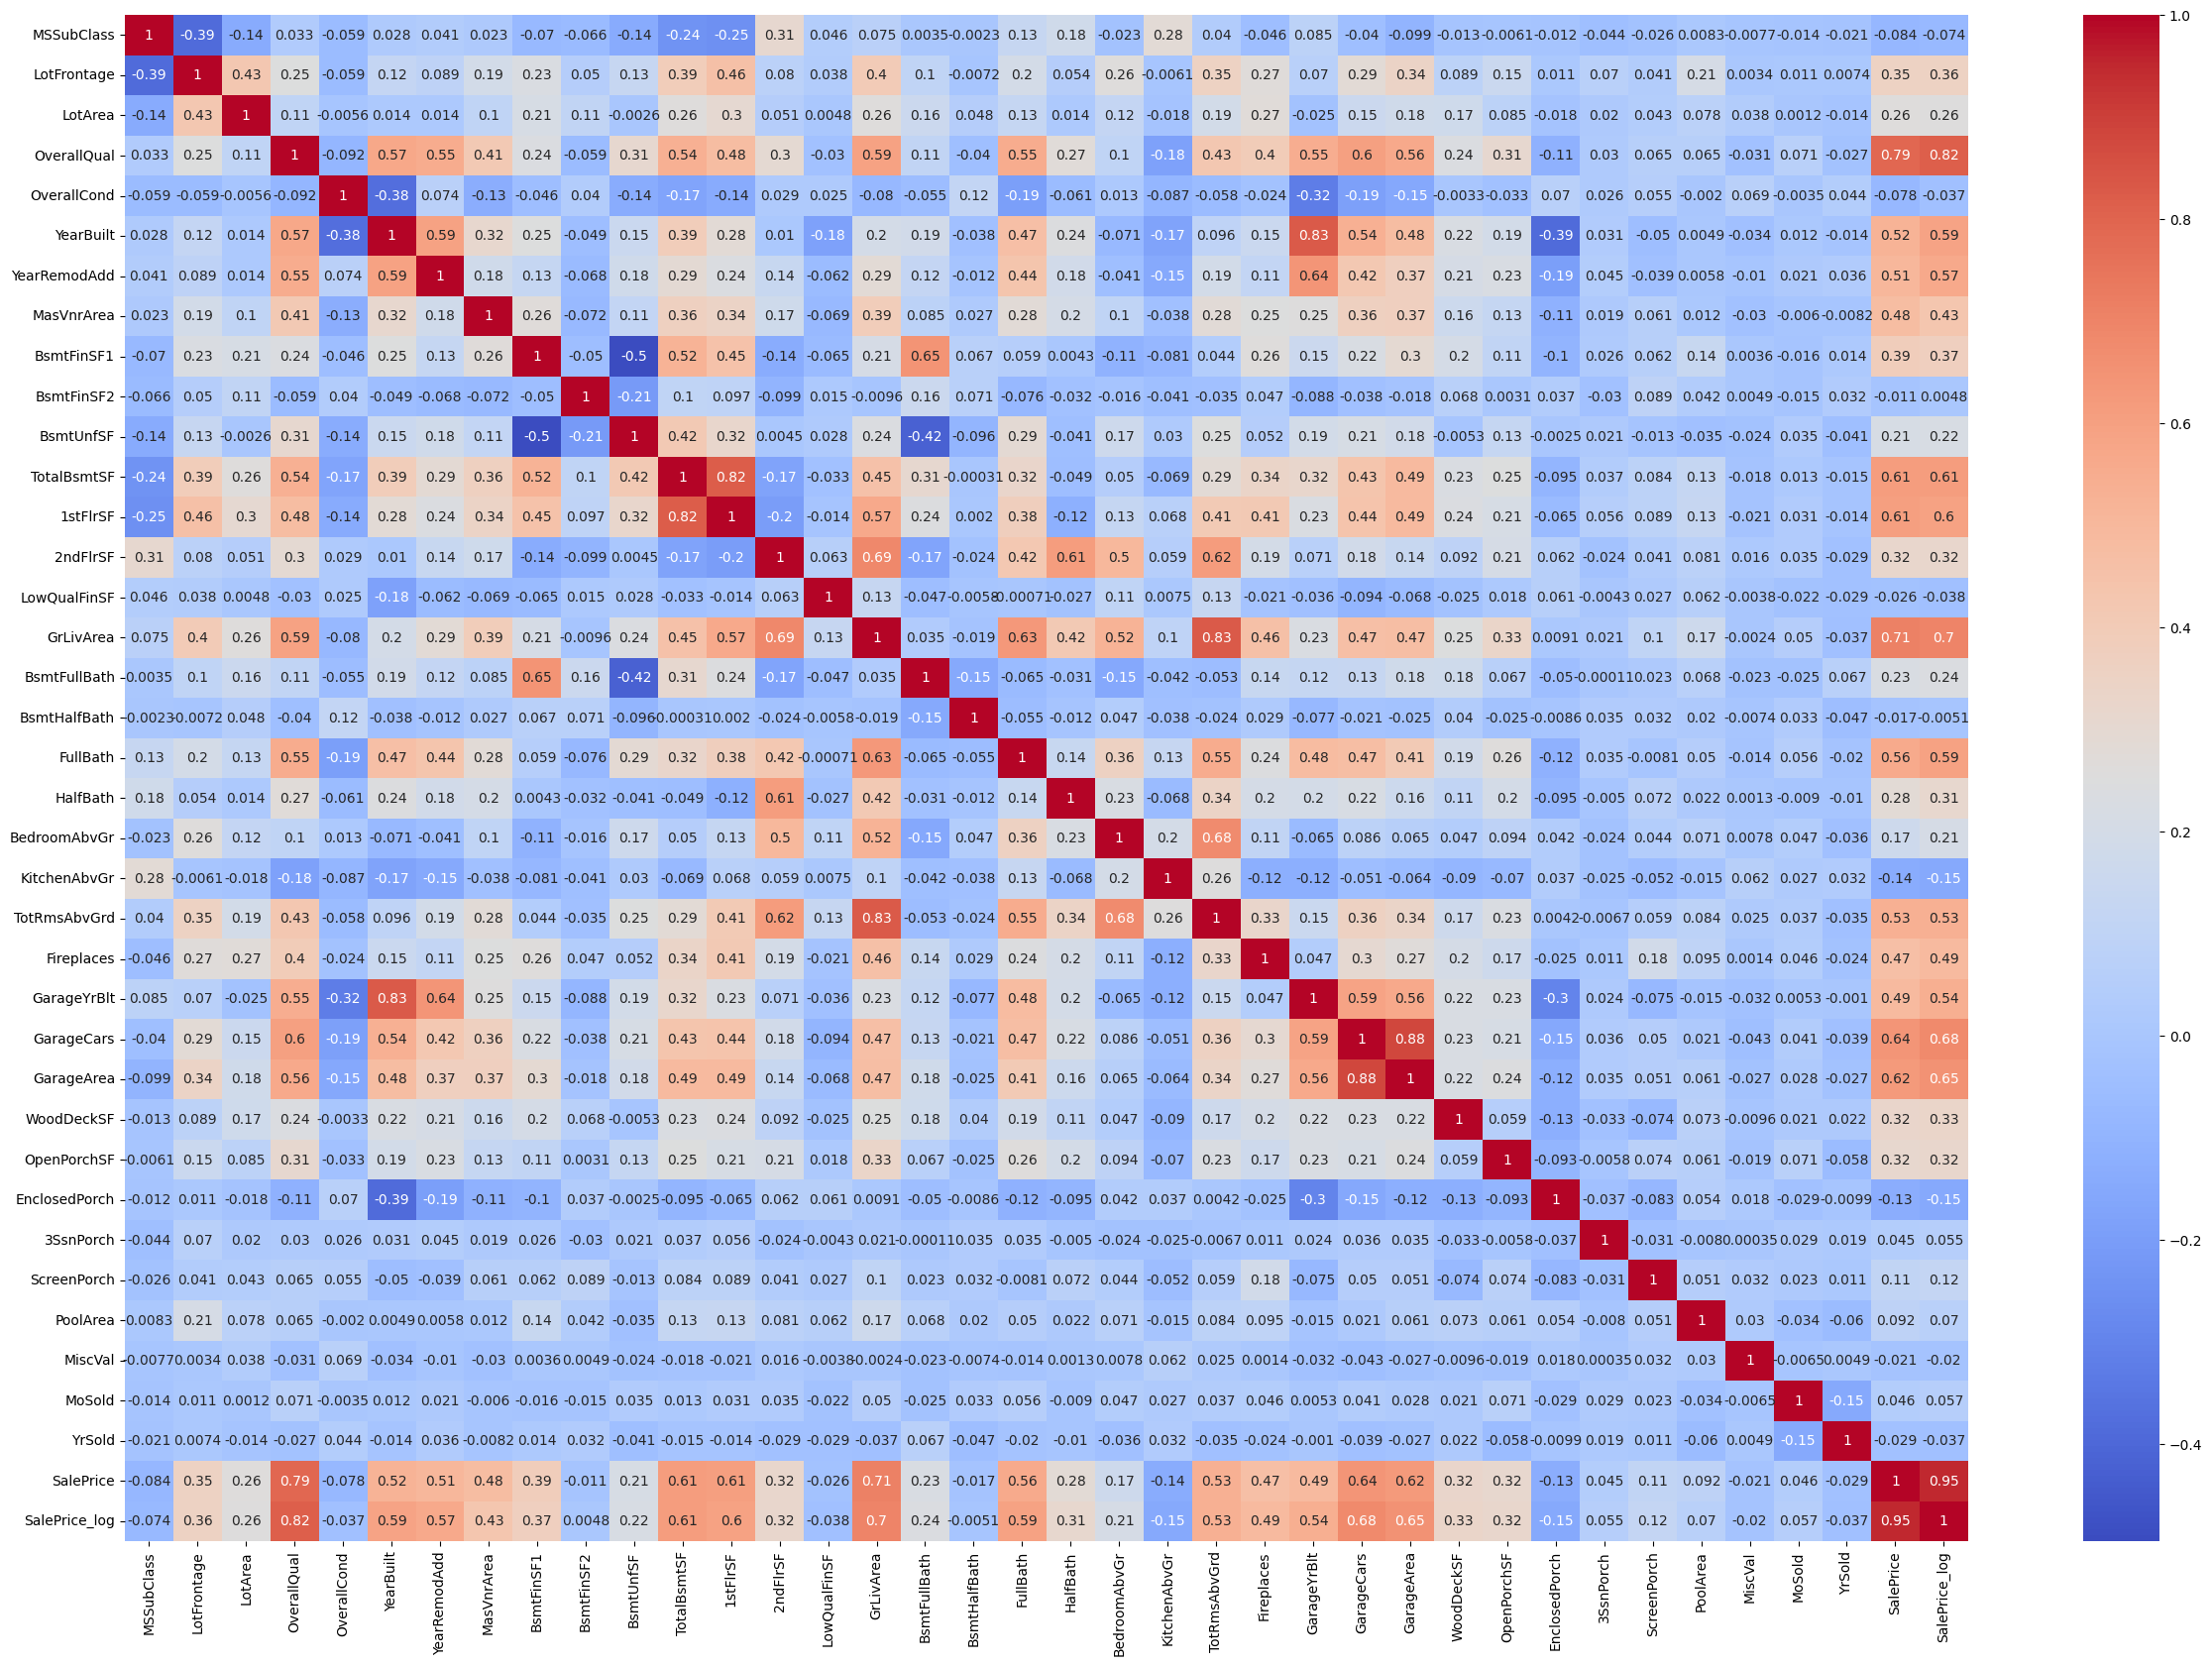

In [4]:
numerical_cols = train_data.select_dtypes(include=['number'])
corr = numerical_cols.corr()
plt.figure(figsize=(30,20))
sns.heatmap(corr, annot=True, cmap='coolwarm')

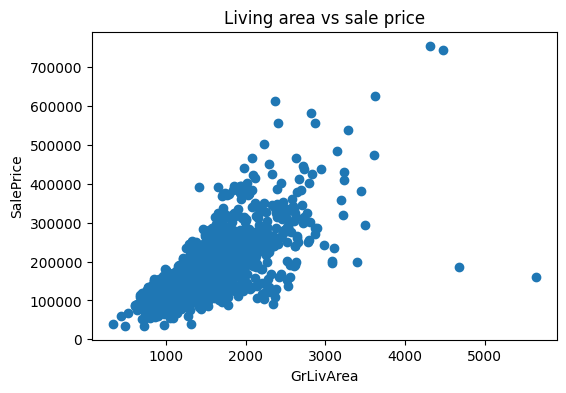

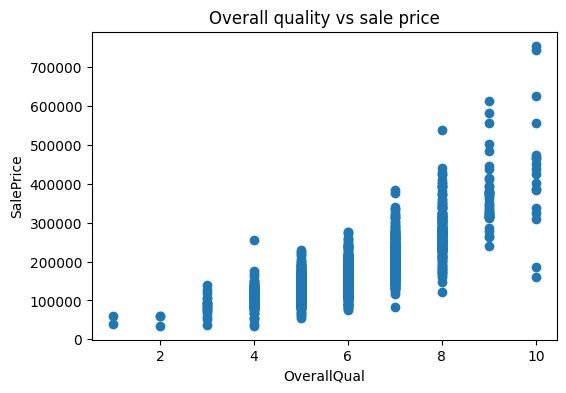

In [5]:
plt.figure(figsize=(6,4))
plt.scatter(x=train_data['GrLivArea'], y=train_data['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title('Living area vs sale price')
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(x=train_data['OverallQual'], y=train_data['SalePrice'])
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.title('Overall quality vs sale price')
plt.show()

In [6]:
train_data = train_data.drop(train_data[(train_data['GrLivArea'] > 4000) & (train_data['SalePrice'] < 300000)].index)

# 4. Handle null/missing values
* Remove columns with too many null values e.g alley, miscfeatures
* Replace null values with 0 (numerical cols) or None (categorical cols)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1458 non-null   int64  
 1   MSZoning       1458 non-null   object 
 2   LotFrontage    1199 non-null   float64
 3   LotArea        1458 non-null   int64  
 4   Street         1458 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1458 non-null   object 
 7   LandContour    1458 non-null   object 
 8   Utilities      1458 non-null   object 
 9   LotConfig      1458 non-null   object 
 10  LandSlope      1458 non-null   object 
 11  Neighborhood   1458 non-null   object 
 12  Condition1     1458 non-null   object 
 13  Condition2     1458 non-null   object 
 14  BldgType       1458 non-null   object 
 15  HouseStyle     1458 non-null   object 
 16  OverallQual    1458 non-null   int64  
 17  OverallCond    1458 non-null   int64  
 18  YearBuilt    

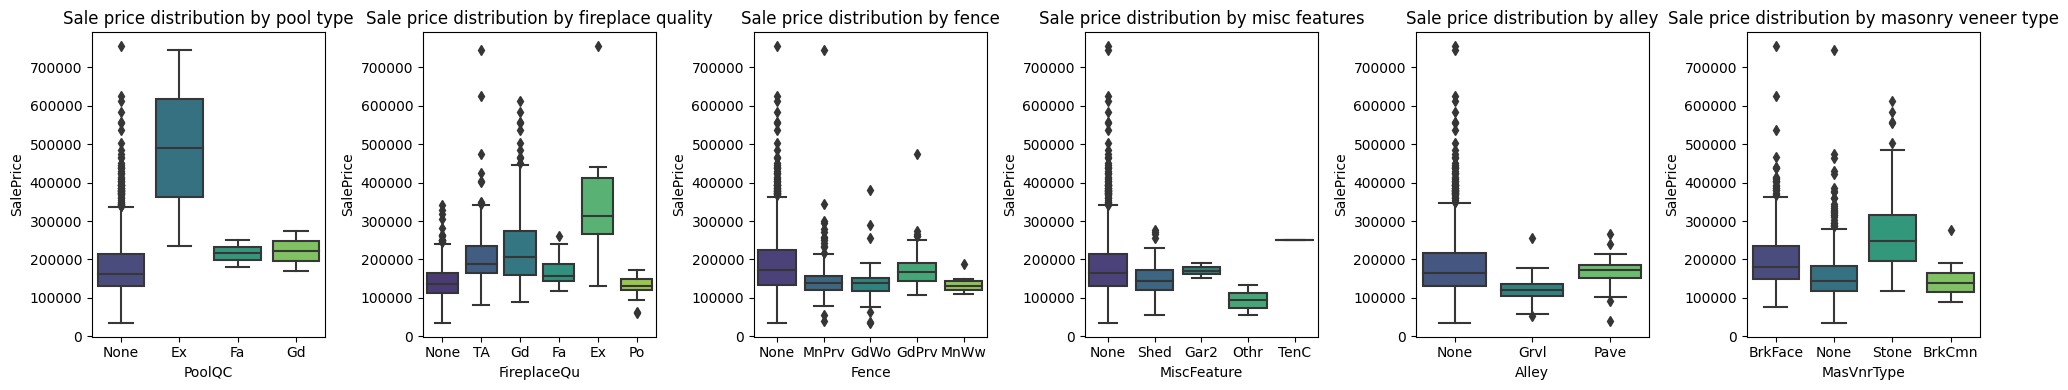

In [8]:
columns_to_fill = ["PoolQC", "FireplaceQu", "Fence", "MiscFeature", "Alley", "MasVnrType"]
for column in columns_to_fill:
    train_data[column] = train_data[column].fillna("None")

# Set up a figure with a row of subplots
fig, axes = plt.subplots(1, 6, figsize=(20, 4))  # 1 row, 6 columns

# List of columns to plot and corresponding titles
columns_to_plot = ["PoolQC", "FireplaceQu", "Fence", "MiscFeature", "Alley", "MasVnrType"]
titles = [
    'Sale price distribution by pool type',
    'Sale price distribution by fireplace quality',
    'Sale price distribution by fence',
    'Sale price distribution by misc features',
    'Sale price distribution by alley',
    'Sale price distribution by masonry veneer type'
]

# Plot each boxplot in a loop
for i, (column, title) in enumerate(zip(columns_to_plot, titles)):
    sns.boxplot(ax=axes[i], x=column, y='SalePrice', data=train_data, palette='viridis')
    axes[i].set_title(title)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('SalePrice')

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Show the plots
plt.show()

In [9]:
all_data = pd.concat((train_data, test_data)).reset_index(drop=True)
all_data.drop(['Alley' , 'Fence', 'MiscFeature'], axis=1, inplace=True)
# these columns have a lot of null values and probably don't have much bearing on the house price
columns_to_fill = ["PoolQC", "FireplaceQu", "MasVnrType"]
for column in columns_to_fill:
    all_data[column] = all_data[column].fillna("None")

In [10]:
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)

In [11]:
numerical_cols = all_data.select_dtypes(include=['number'])
#all_data[numerical_cols.columns] = numerical_cols.fillna(0)

categorical_cols = all_data.select_dtypes(include=['object'])
#all_data[categorical_cols.columns] = categorical_cols.fillna("None")

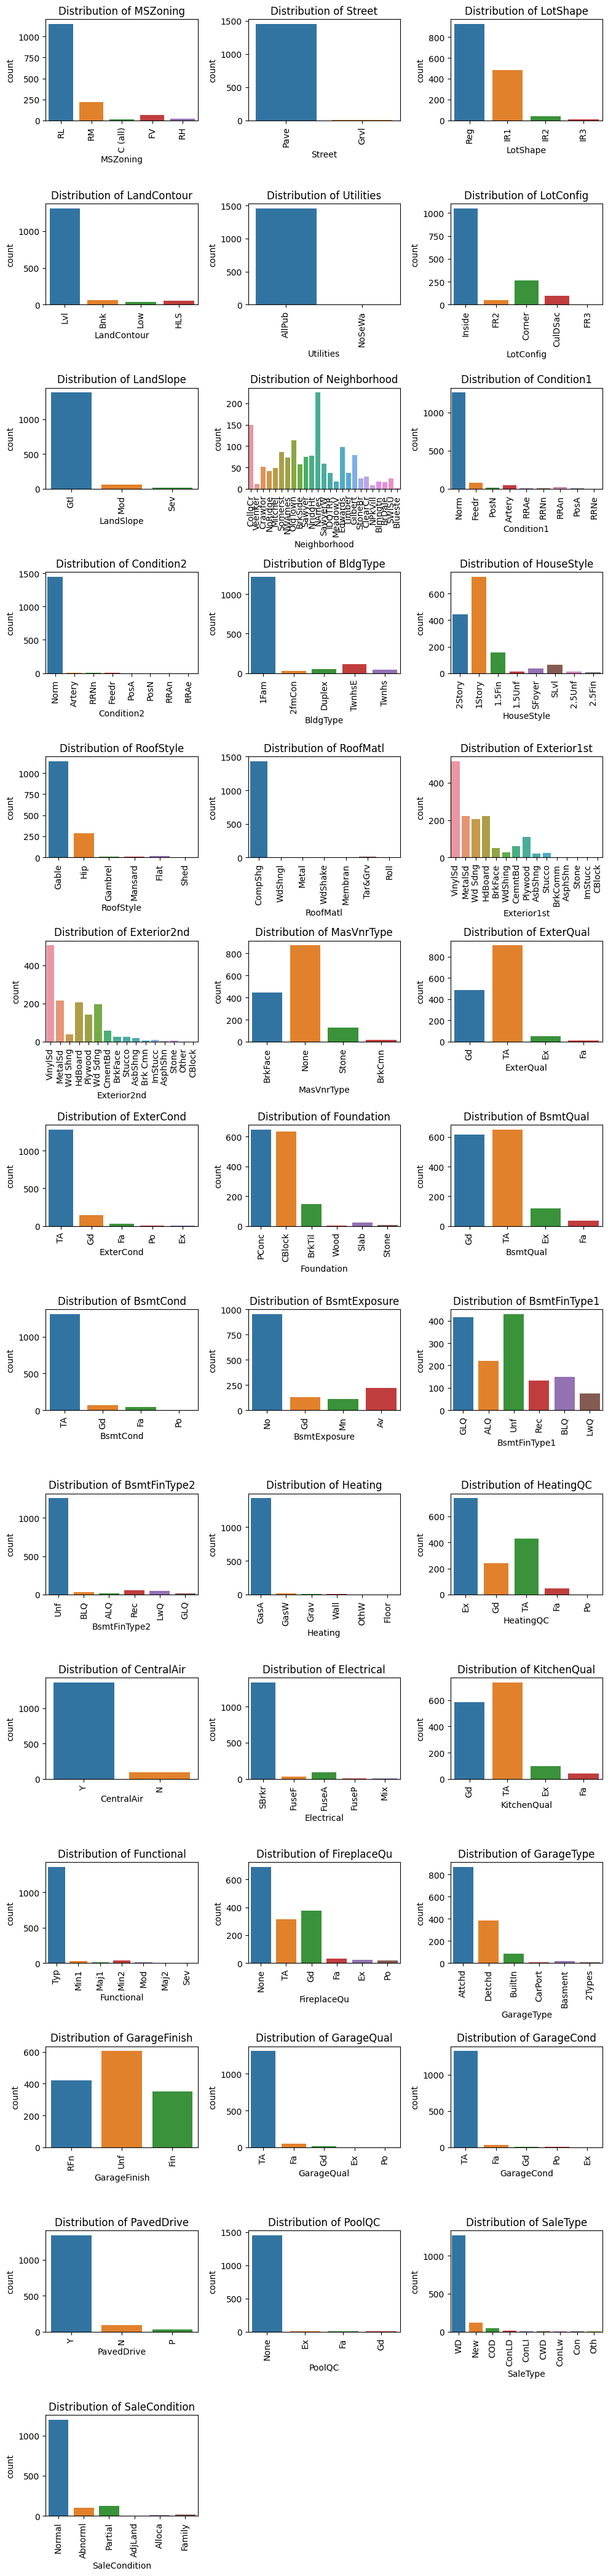

In [12]:
num_categories = len(categorical_cols.columns)

# Define number of columns for subplot grid (e.g., 3 columns per row)
num_cols = 3
num_rows = (num_categories + num_cols - 1) // num_cols  # Compute the number of rows needed

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for i, col in enumerate(categorical_cols.columns):
    sns.countplot(data=train_data, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels if necessary

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [13]:
cols_to_replace_with_most_common = ['SaleType', 'Electrical', 'KitchenQual', 'MSZoning', 'Exterior1st', 'Exterior2nd', 'Functional']
for col in cols_to_replace_with_most_common:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [14]:
all_data.drop(['Utilities'], axis=1, inplace=True)
print(all_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2917 non-null   int64  
 1   MSZoning       2917 non-null   object 
 2   LotFrontage    2431 non-null   float64
 3   LotArea        2917 non-null   int64  
 4   Street         2917 non-null   object 
 5   LotShape       2917 non-null   object 
 6   LandContour    2917 non-null   object 
 7   LotConfig      2917 non-null   object 
 8   LandSlope      2917 non-null   object 
 9   Neighborhood   2917 non-null   object 
 10  Condition1     2917 non-null   object 
 11  Condition2     2917 non-null   object 
 12  BldgType       2917 non-null   object 
 13  HouseStyle     2917 non-null   object 
 14  OverallQual    2917 non-null   int64  
 15  OverallCond    2917 non-null   int64  
 16  YearBuilt      2917 non-null   int64  
 17  YearRemodAdd   2917 non-null   int64  
 18  RoofStyl

In [15]:
all_data[numerical_cols.columns] = numerical_cols.fillna(0)
all_data[categorical_cols.columns] = categorical_cols.fillna("None")

In [16]:
missing_data = all_data.isnull().sum()
missing_data = missing_data.drop(missing_data[missing_data == 0].index)
print(missing_data)

Series([], dtype: int64)


# 5. Analysing how features correlate and affect each other

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

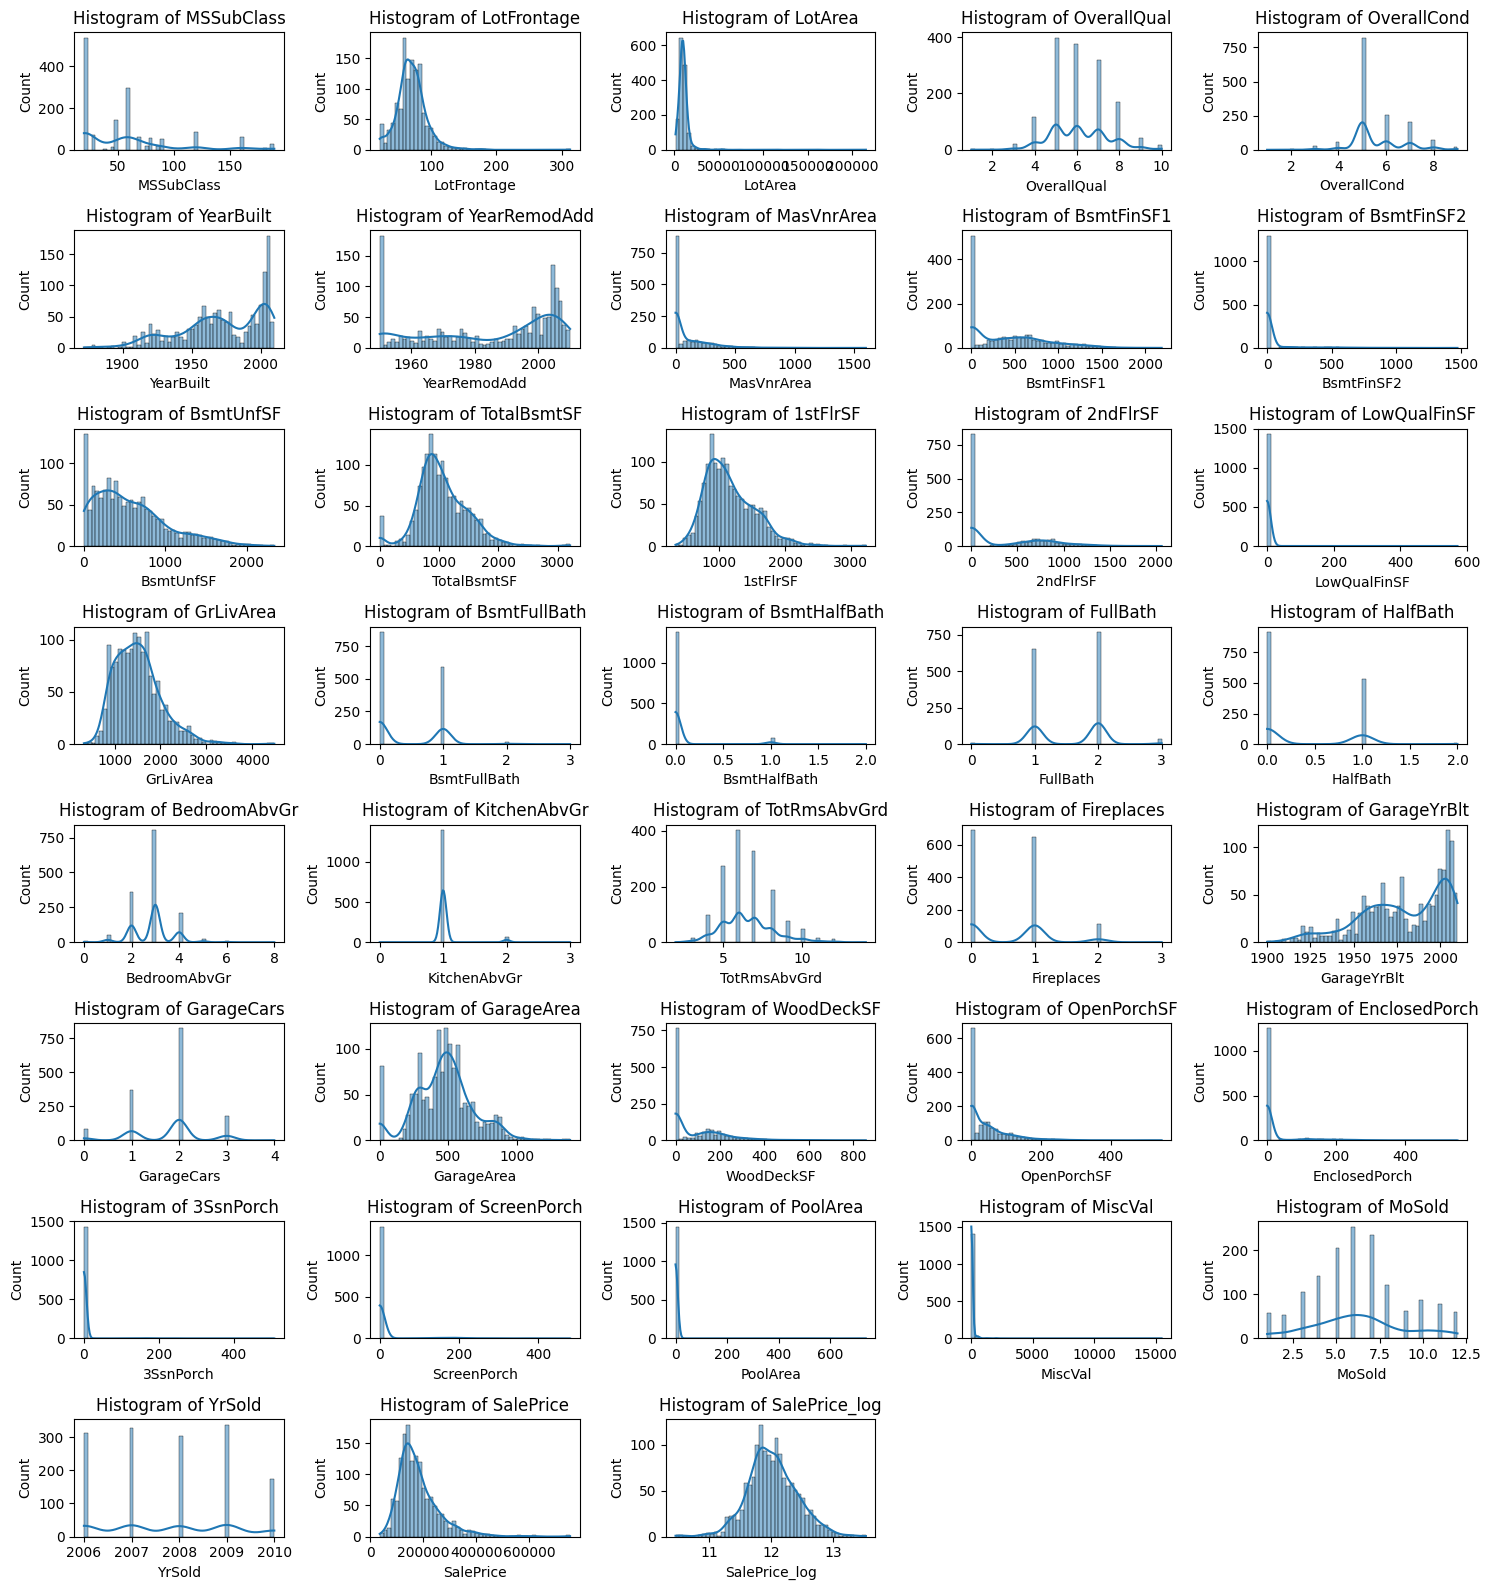

In [17]:
# get all numeric features
numerical_cols = train_data.select_dtypes(include=['number'])
plots_per_row = 5
total_plots = len(numerical_cols.columns)
total_rows = np.ceil(total_plots / plots_per_row).astype(int)

# Create subplots
fig, axes = plt.subplots(total_rows, plots_per_row, figsize=(15, total_rows * 2)) # Adjust figsize as needed

# Flatten axes array for easy iteration if more than one row
axes = axes.flatten() if total_rows > 1 else [axes]

# Loop through each numeric column and plot in the corresponding subplot
for i, column in enumerate(numerical_cols.columns):
    sns.histplot(train_data[column].dropna(), kde=True, bins=50, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [18]:
print(train_data.groupby('Street')['SalePrice'].mean())
print(train_data.groupby('Street')['SalePrice'].count())
all_data.drop(['Street'], axis=1, inplace=True)

Street
Grvl    130190.500000
Pave    181142.598485
Name: SalePrice, dtype: float64
Street
Grvl       6
Pave    1452
Name: SalePrice, dtype: int64


In [19]:
print(train_data.groupby('PavedDrive')['SalePrice'].mean())
print(train_data.groupby('PavedDrive')['SalePrice'].count())

PavedDrive
N    115039.122222
P    132330.000000
Y    186454.988789
Name: SalePrice, dtype: float64
PavedDrive
N      90
P      30
Y    1338
Name: SalePrice, dtype: int64


In [20]:
print(train_data.groupby('LandSlope')['SalePrice'].mean())
print(train_data.groupby('LandSlope')['SalePrice'].count())

LandSlope
Gtl    179967.787681
Mod    196734.138462
Sev    204379.230769
Name: SalePrice, dtype: float64
LandSlope
Gtl    1380
Mod      65
Sev      13
Name: SalePrice, dtype: int64


In [21]:
# mssubclass is actually categorical and not a number - to not confuse our model e.g it assuming an order lets make it a category
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

# same with year/month sold - these aren't necessarily numerical values
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['YearRemodAdd'] = all_data['YearRemodAdd'].astype(str)

In [22]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Assume all_data and n_train are defined, and all_data is a DataFrame
train_data = all_data[:n_train]

# One-Hot Encoding for categorical variables, including 'Street'
train_data_encoded = pd.get_dummies(train_data)

# Display the first few rows of the encoded data
print(train_data_encoded.head())

# Separate features and target variable
X = train_data_encoded.drop('SalePrice', axis=1)
y = train_data_encoded['SalePrice']

# Fit RandomForest to check feature importance
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X, y)

# Check feature importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# Create a DataFrame for better formatting
importance_df = pd.DataFrame({
    'Feature': feature_importances.index,
    'Importance': feature_importances.values
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Reset float format to avoid scientific notation
pd.set_option('display.float_format', lambda x: '%.8f' % x)

# Print the importance value of the specific feature 'Street'
print(importance_df)
feature_name = 'Street'
importance_value = importance_df.loc[importance_df['Feature'] == feature_name, 'Importance']

if not importance_value.empty:
    print(importance_value.values[0])
else:
    # If the feature is not found, print a default message or value
    print('Feature not found')

# Reset float format to default
pd.reset_option('display.float_format')

   LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  MasVnrArea  \
0         65.0     8450            7            5       2003       196.0   
1         80.0     9600            6            8       1976         0.0   
2         68.0    11250            7            5       2001       162.0   
3         60.0     9550            7            5       1915         0.0   
4         84.0    14260            8            5       2000       350.0   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  ...  SaleType_Oth  \
0       706.0         0.0      150.0        856.0  ...         False   
1       978.0         0.0      284.0       1262.0  ...         False   
2       486.0         0.0      434.0        920.0  ...         False   
3       216.0         0.0      540.0        756.0  ...         False   
4       655.0         0.0      490.0       1145.0  ...         False   

   SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0         True                  False         

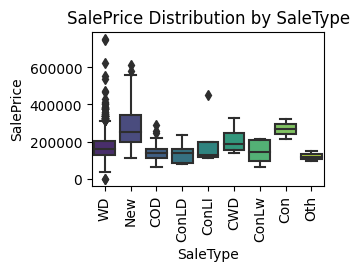

In [23]:
plt.figure(figsize=(3, 2))
sns.boxplot(x='SaleType', y='SalePrice', data=train_data, palette='viridis')
plt.title('SalePrice Distribution by SaleType')
plt.xticks(rotation=90)
plt.xlabel('SaleType')
plt.ylabel('SalePrice')
plt.show()

['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']


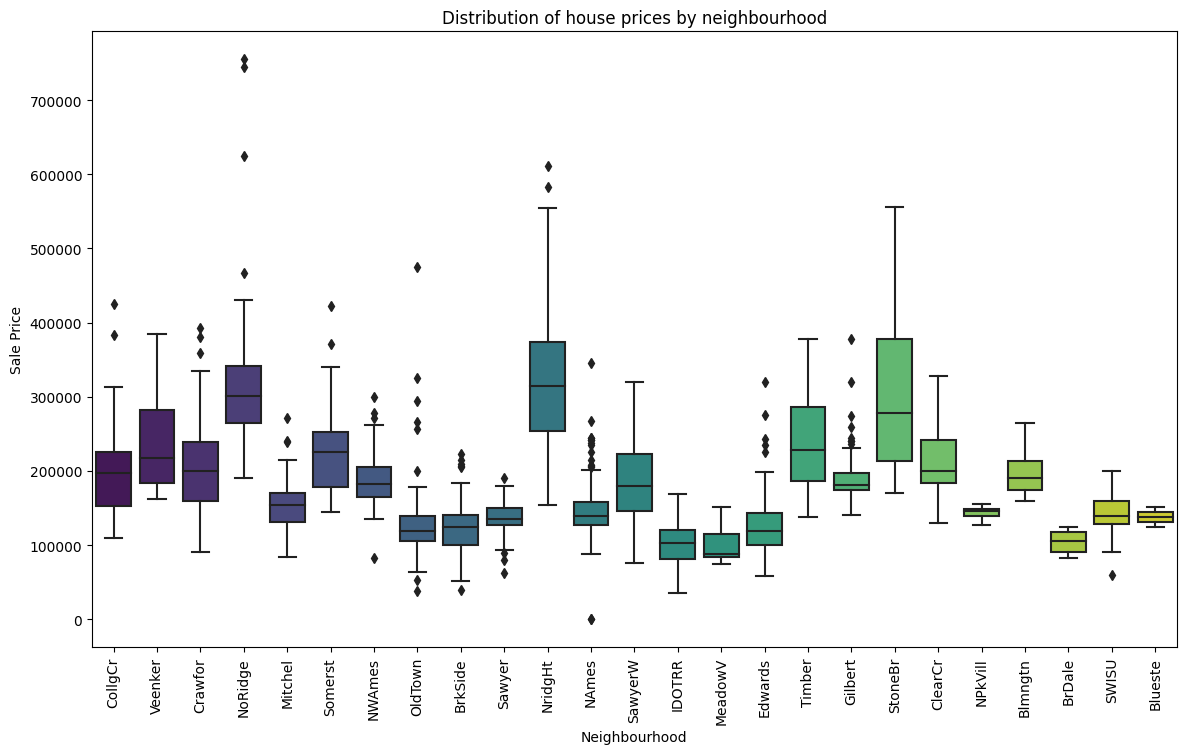

In [24]:
print(train_data['Neighborhood'].unique())
mean_by_neighbourhoods = train_data.groupby('Neighborhood')['SalePrice'].mean()
plt.figure(figsize=(14,8))
sns.boxplot(x="Neighborhood", y="SalePrice", data=train_data, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Neighbourhood")
plt.ylabel("Sale Price")
plt.title("Distribution of house prices by neighbourhood")
plt.show()

In [25]:
from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [26]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBathrooms'] = (all_data['BsmtFullBath'] + all_data['BsmtHalfBath'] * 0.5 + all_data['FullBath'] + all_data['HalfBath'] * 0.5)

In [27]:
all_data = pd.get_dummies(all_data)
final_train = all_data[:n_train]
final_test = all_data[n_test-1:]

# 6. Creating the model

In [28]:
print(final_train.info())
print(final_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 284 entries, MSSubClass to Utilities_None
dtypes: bool(225), float64(16), int64(43)
memory usage: 993.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 1458 to 2916
Columns: 284 entries, MSSubClass to Utilities_None
dtypes: bool(225), float64(16), int64(43)
memory usage: 993.2 KB
None


In [29]:
print(final_train['SalePrice_log'])
print(final_test['SalePrice_log'])

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.493130
1456    11.864462
1457    11.901583
1458     0.000000
1459     0.000000
Name: SalePrice_log, Length: 1460, dtype: float64
1458    0.0
1459    0.0
1460    0.0
1461    0.0
1462    0.0
       ... 
2912    0.0
2913    0.0
2914    0.0
2915    0.0
2916    0.0
Name: SalePrice_log, Length: 1459, dtype: float64


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Prepare the Data
# Separate features and target variable
X_train = final_train.drop(columns=['SalePrice', 'SalePrice_log'], axis=1)  # Features
y_train = final_train['SalePrice']  # Target variable
X_test = final_test.drop(columns=['SalePrice', 'SalePrice_log'], axis=1)

# 3. Train the Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# 4. Evaluate the Model
# Make predictions
y_train_pred = model.predict(X_train)

# Calculate performance metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f"Mean Absolute Error: {mae_train:.2f}")
print(f"Mean Squared Error: {mse_train:.2f}")
print(f"R² Score: {r2_train:.2f}")

# 5. Make Predictions
# Example: Predicting the sale price for new data
# new_data = ...  # Your new data here
# predictions = model.predict(new_data)
y_test_pred = model.predict(X_test)

# You can save the predictions or use them as needed
# For example, saving predictions to a CSV file:
predictions_df = pd.DataFrame({'Id': final_test['Id'].astype(int), 'SalePrice': y_test_pred})
print(predictions_df)
predictions_df.to_csv('predictions.csv', index=False)

Mean Absolute Error: 6186.92
Mean Squared Error: 97662953.80
R² Score: 0.98
        Id  SalePrice
1458  1461   51100.50
1459  1462   64216.00
1460  1463  179032.74
1461  1464  180953.74
1462  1465  194380.98
...    ...        ...
2912  2915   79458.00
2913  2916   77824.71
2914  2917  164016.96
2915  2918  115579.50
2916  2919  228229.38

[1459 rows x 2 columns]
